# Multi-Class Classification - Scalp EEG

Here, we run through a validation analysis of scalp EEG data for the purposes of predicting epilepsy. We separate epilepsy into normal vs abnormal EEG to allow for differences

In [1]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle
import warnings

warnings.filterwarnings("ignore")

import sklearn
from sklearn.preprocessing import OrdinalEncoder, label_binarize
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
    make_scorer
)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (
    StratifiedGroupKFold,
    StratifiedShuffleSplit,
    cross_validate,
)
from sklearn.multiclass import OneVsRestClassifier

from sklearn.utils import resample

import mne

mne.set_log_level("ERROR")
from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals

from eztrack.io import read_derivative_npy

# if you installed sporf via README
# from oblique_forests.sporf import ObliqueForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sample_code.features import (
    calculate_distribution,
    calculate_entropy,
    calculate_variance,
    calculate_kl_div,
    calculate_skew,
    calculate_kurtosis,
)

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sklearn

# this should be at least 1.0
print(sklearn.__version__)

1.1.dev0


In [3]:
from sklearn import preprocessing

enc = preprocessing.OrdinalEncoder()

## Define Run Parameters

In [4]:
# Group name keys, assigned y-label values
experimental_condition_map = {
    "non-epilepsy-normal-eeg": 0,
    "epilepsy-normal-eeg": 1,
    "epilepsy-abnormal-eeg": 2,
}

reference = "monopolar"
radius = "1.25"

remove_C3C4 = False
alpha_O1O2 = True

include_centers = ['jhh']

# Define possible helper functions

In [5]:
class NumpyEncoder(json.JSONEncoder):
    """Special json encoder for numpy types.

    Pass to json.dump(), or json.load().
    """

    def default(self, obj):  # noqa
        if isinstance(
            obj,
            (
                np.int_,
                np.intc,
                np.intp,
                np.int8,
                np.int16,
                np.int32,
                np.int64,
                np.uint8,
                np.uint16,
                np.uint32,
                np.uint64,
            ),
        ):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):  # This is the fix
            return obj.tolist()
        elif isinstance(obj, (datetime, date)):
            return obj.isoformat()
        return json.JSONEncoder.default(self, obj)

In [6]:
def plot_subject_feature_map(dataset, desired_subject, feature_name):
    for idx, subject in enumerate(dataset["subject"]):
        if subject != desired_subject:
            continue

        # get the metadata
        ch_names = dataset["ch_names"][idx]

        # get the data
        feature_map = dataset[feature_name][idx]

        x = np.arange(feature_map.shape[1])

        sns.set_context("paper", font_scale=1.75)
        fig, ax = plt.subplots()

        y_mean = feature_map.mean(axis=0)
        y_sem = scipy.stats.sem(feature_map, axis=0)
        ax.plot(x, y_mean, color="red")
        ax.fill_between(x, y_mean - y_sem, y_mean + y_sem, color="red", alpha=0.5)

        ax.set(
            title=f"Subject {subject} - {feature_name}",
            xlabel="Time (A.U.)",
            ylabel=f"{feature_name} Value",
        )
        ax.legend()
        break

In [7]:
def _load_subject_derivs(
    deriv_path, read_func, subjects=None, search_str="*.npy", dataset=None
):
    if subjects is None:
        subjects = get_entity_vals(deriv_path, "subject")

    print(f"Loading data for subjects: {subjects}")

    if dataset is None:
        dataset = collections.defaultdict(list)
    for subject in subjects:
        subj_path = deriv_path / f"sub-{subject}"

        # get all files of certain search_str
        fpaths = subj_path.glob(search_str)

        # now load in all file paths
        for fpath in fpaths:
            deriv = read_func(fpath, source_check=False)

            bids_params = get_entities_from_fname(fpath.name, on_error="ignore")
            session = bids_params["session"]
            task = bids_params["task"]
            run = bids_params["run"]

            # extract data
            ch_names = deriv.ch_names
            deriv_data = deriv.get_data()

            dataset["subject"].append(subject)
            dataset["data"].append(deriv_data)
            dataset["ch_names"].append(ch_names)
            dataset["session"].append(session)
            dataset["task"].append(task)
            dataset["run"].append(run)

    return dataset

In [8]:
def _get_exp_condition(subject, root):
    part_fname = os.path.join(root, "participants.tsv")
    df = pd.read_csv(part_fname, sep="\t")
    if not subject.startswith("sub-"):
        subject = f"sub-{subject}"

    return df[df["participant_id"] == subject]

In [9]:
def _features_from_spatiotemporal_heatmap(deriv_data):
    # Calculate distribution of values over time for the spatiotemporal heatmap

    features = np.hstack(
        (
            deriv_data.mean(axis=1),
            deriv_data.std(axis=1),
        ),
        #         axis=0,
    )
    return features

In [10]:
def get_Xy_matrix(dataset, feature_set):
    X = []
    y = []
    subjects = []

    for idx, subject in enumerate(dataset["subject"]):
        X_buff = []
        for feature_name in feature_set:
            feature = dataset[feature_name][idx]
            if isinstance(feature, float):
                feat = [feature]
            elif isinstance(feature, np.ndarray):
                feat = list(feature)
            else:
                feat = feature
            feat = [feature] if isinstance(feature, float) else feature
            X_buff.extend(feat)
        X_buff = np.array(X_buff)

        X.append(X_buff)
        y.append(dataset["group"][idx] > 0)
        subjects.append(subject)
    return X, y, subjects

In [11]:
def convert_experimental_cond_to_y(experimental_condition_list):
    return [experimental_condition_map[cond] for cond in experimental_condition_list]

# Define data directories

In [12]:
jhroot = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
jeffroot = Path("D:/OneDriveParent/Johns Hopkins/Jefferson_Scalp - Documents/root")

# not ready yet
upmcroot = Path(
    "D:/OneDriveParent/Johns Hopkins/UPMC_Scalp - Documents/scalp_study/root"
)

In [13]:
jh_deriv_root = jhroot / "derivatives"
jeff_deriv_root = jeffroot / "derivatives"
jh_source_root = jhroot / "sourcedata"
jeff_source_root = jeffroot / "sourcedata"

# define derivative chains
ss_deriv_chain = Path("sourcesink") / reference
#remove_C3C4 = False
#alpha_O1O2 = False
if alpha_O1O2:
    ss_deriv_chain = ss_deriv_chain / "filter-alpha_O1O2"
if remove_C3C4:
    ss_deriv_chain = ss_deriv_chain / "remove-C3C4"

frag_deriv_chain = Path("fragility") / f"radius{radius}" / reference
if alpha_O1O2:
    frag_deriv_chain = frag_deriv_chain / "filter-alpha_O1O2"
if remove_C3C4:
    frag_deriv_chain = frag_deriv_chain / "remove-C3C4"

# define final path
jh_ss_deriv_dir = jh_deriv_root / ss_deriv_chain
jeff_ss_deriv_dir = jeff_deriv_root / ss_deriv_chain
jh_frag_deriv_dir = jh_deriv_root / frag_deriv_chain
jeff_frag_deriv_dir = jeff_deriv_root / frag_deriv_chain

combined_deriv_dir = Path(
    "D:/OneDriveParent/OneDrive - Johns Hopkins/Scalp_EEG_combined/derivatives"
)

In [14]:
dataset = _load_subject_derivs(
    jh_ss_deriv_dir,
    read_func=read_derivative_npy,
    subjects=None,
    search_str="*desc-ssindmatrix*.npy",
)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh029\sub-jhh029_task-awake_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh030\sub-jhh030_task-awake_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh101\sub-jhh101_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh102\sub-jhh102_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh103\sub-jhh103_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

## Plot a single subject to test

(16, 783)


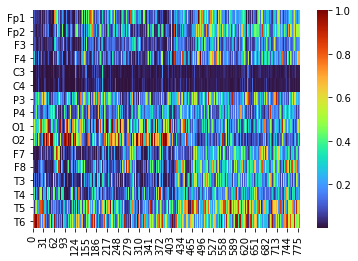

In [15]:
desired_subject = "jhh001"
feature_name = "ssentropy"

idx = dataset["subject"].index(desired_subject)
data = dataset["data"][idx]
ch_names = dataset["ch_names"][idx]
print(data.shape)


fig, ax = plt.subplots()
sns.heatmap(data, cmap="turbo", yticklabels=ch_names, ax=ax)

plt.show()

# Define Cross Validation Experiment

In [16]:
n_splits = 10
train_size = 0.7
random_state = 12345

In [17]:
cv = StratifiedGroupKFold(
    n_splits=n_splits,
    random_state=random_state,
    shuffle=True,
)
cv = StratifiedShuffleSplit(
    n_splits=n_splits,
    train_size=train_size,
    random_state=random_state,
)

## Form Features from SpatioTemporal Heatmaps

In [18]:
X = []
y = []
subjects = []
sessions = []
tasks = []
runs = []

for idx in range(len(dataset["subject"])):
    subject = dataset["subject"][idx]
    session = dataset["session"][idx]
    task = dataset["task"][idx]
    run = dataset["run"][idx]

    ch_names = dataset["ch_names"][idx]
    deriv_data = dataset["data"][idx]

    # extract features
    X_ = _features_from_spatiotemporal_heatmap(deriv_data)

    # extract outcome
    if "jhh" in subject:
        root = jhroot
    elif "jeff" in subject:
        root = jeffroot
    elif "upmc" in subject:
        root = upmcroot
    subj_df = _get_exp_condition(subject, root)
    outcome = subj_df["exp_condition"].values[0].strip()
    X.append(X_)
    y.append(outcome)
    subjects.append(subject)
    sessions.append(session)
    tasks.append(task)
    runs.append(run)
    
X = np.array(X)
y_encode = np.array(y)
subjects = np.array(subjects)
sessions = np.array(sessions)
tasks = np.array(tasks)
runs = np.array(runs)

print(X.shape, y_encode.shape)

(92, 32) (92,)


In [19]:
print(y)
y = np.array(convert_experimental_cond_to_y(y_encode))
n_classes = 3
#y_binary = label_binarize(y, classes=[0,1,2])

print(X.shape)
print(y.shape)
print(y)
#print(y_binary)

['non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'epilepsy-normal-eeg', 'epilepsy-normal-eeg', 'epilepsy-normal-eeg', 'epilepsy-normal-eeg', 'epilepsy-normal-eeg', 'epilepsy-normal-eeg

## Define Classification Models

In [20]:
clf_name = "rf"
max_features = X.shape[1]
n_features = max_features

rf_model_params = {
    "n_estimators": 1000,
    "max_features": max_features,
    "n_jobs": -1,
    "random_state": random_state,
}

In [21]:
if clf_name == "rf":
    clf = RandomForestClassifier(**rf_model_params)
elif clf_name == "sporf":
    # only used if you installed cysporf
    clf = ObliqueForestClassifier(**rf_model_params)
elif clf_name == "lr":
    clf = LogisticRegression(**lr_model_params)
#clf = OneVsRestClassifier(clf)

# Run sklearn.cross_validate

In [22]:
scoring_funcs = {
    "roc_auc": roc_auc_score,
    "accuracy": accuracy_score,
    #"precision_macro": "",
    "neg_brier_score": brier_score_loss,
    #"recall_macro": "",
    #"f1_macro": "",
}

# Only one scorer for now

#scores = dict()
#for sname, sfunc in scoring_funcs.items():
#    myscore = make_scorer(sfunc, multi_class='ovo',needs_proba=True)
#    scores[sname] = myscore
myscore = make_scorer(roc_auc_score, multi_class='ovo',needs_proba=True)

# run cross-validation
scores = cross_validate(
    clf,
    X,
    y,
    groups=None,
    cv=cv,
    scoring=myscore,
    return_estimator=True,
    return_train_score=True,
    n_jobs=1,
    error_score='raise'
)

# get the estimators
estimators = scores.pop("estimator")

In [23]:
print("Using estimator ", estimators[0])

# initialize keys to list
for key in [
    "test_fraction_pos",
    "test_mean_pred_value",
    "test_fpr",
    "test_tpr",
    "test_fnr",
    "test_tnr",
    "test_thresholds",
    "train_fraction_pos",
    "train_mean_pred_value",
    "train_y_pred_proba",
    "train_fpr",
    "train_tpr",
    "train_fnr",
    "train_tnr",
    "train_thresholds",
    "train_subjects",
    "test_subjects",
    "test_y_pred_proba",
    "test_importances",
    "test_specificity",
    "test_y",
    "test_y_encodings",
]:
    scores[key] = []

for idx, (train_inds, test_inds) in enumerate(cv.split(X, y)):
    estimator = estimators[idx]

    # append subjects
    scores["train_subjects"].append(subjects[train_inds])
    scores["test_subjects"].append(subjects[test_inds])
    scores["test_y"].append(y[test_inds])
    scores["test_y_encodings"].append(y_encode[test_inds])

    # evaluate on the test set
    y_train = y[train_inds]
    X_train = X[train_inds, :]
    y_pred_prob_ = estimator.predict_proba(X_train)
    y_pred_prob = y_pred_prob_[:, 1]

    # Cannot do calibration curves for multi-class. Cannot find any equivalent
    # compute calibration curve
    #fraction_of_positives, mean_predicted_value = calibration_curve(
    #    y_train, y_pred_prob, n_bins=10, strategy="quantile"
    #)

    # append training data
    scores["train_y_pred_proba"].append(y_pred_prob_)
    #scores["train_fraction_pos"].append(fraction_of_positives)
    #scores["train_mean_pred_value"].append(mean_predicted_value)

    # store ROC curve metrics on the held-out test set
    # perform roc curve per class to account for multi-class classification
    fpr = dict()
    tpr = dict()
    fnr = dict()
    tnr = dict()
    roc_auc = dict()
    thresholds = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_train, y_pred_prob_[:, i], pos_label=1)
        fnr[i], tnr[i], _ = roc_curve(y_train, y_pred_prob_[:, i], pos_label=0)
        roc_auc[i] = auc(fpr[i], tpr[i])

    scores["train_fpr"].append(fpr)
    scores["train_tpr"].append(tpr)
    scores["train_fnr"].append(fnr)
    scores["train_tnr"].append(tnr)
    scores["train_thresholds"].append(thresholds)

    # evaluate on the test set
    y_test = y[test_inds]
    X_test = X[test_inds, :]
    y_pred_prob_ = estimator.predict_proba(X_test)
    y_pred_prob = y_pred_prob_[:, 1]

    # Cannot do calibration curves for multi-class. Cannot find any equivalent
    # compute calibration curve
    #fraction_of_positives, mean_predicted_value = calibration_curve(
    #    y_test, y_pred_prob, n_bins=10, strategy="quantile"
    #)

    # append testing data
    scores["test_y_pred_proba"].append(y_pred_prob_)
    #scores["test_fraction_pos"].append(fraction_of_positives)
    #scores["test_mean_pred_value"].append(mean_predicted_value)

    # store ROC curve metrics on the held-out test set
    # perform roc curve per class to account for multi-class classification
    fpr = dict()
    tpr = dict()
    fnr = dict()
    tnr = dict()
    roc_auc = dict()
    thresholds = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test, y_pred_prob_[:, i], pos_label=1)
        fnr[i], tnr[i], _ = roc_curve(y_test, y_pred_prob_[:, i], pos_label=0)
        roc_auc[i] = auc(fpr[i], tpr[i])

    scores["test_fpr"].append(fpr)
    scores["test_tpr"].append(tpr)
    scores["test_fnr"].append(fnr)
    scores["test_tnr"].append(tnr)
    scores["test_thresholds"].append(thresholds)

    C = confusion_matrix(
        y_test.astype(int), (y_pred_prob > 0.5).astype(int)
    )
    
    classes=[0,1,2]
    sensitivity = dict()
    specificity = dict()
    for i in range(n_classes):
        sensitivity[i] = C[i, i] / sum(C[i,:])
        if i == 0:
            specificity[i] = (C[1,1]+C[2,2]) / (C[1,0]+C[2,0]+C[1,1]+C[2,2])
        elif i == 1:
            specificity[i] = (C[0,0]+C[2,2]) / (C[0,1]+C[2,1]+C[0,0]+C[2,2])
        else:
            specificity[i] = (C[0,0]+C[1,1]) / (C[0,2]+C[1,2]+C[0,0]+C[1,1])
    
    
    scores["test_specificity"].append(specificity)

    # get the permutation importances
    r = permutation_importance(
        estimator, X_test, y_test, n_repeats=5, random_state=random_state, n_jobs=-1
    )
    scores["test_importances"].append(r.importances)

Using estimator  RandomForestClassifier(max_features=32, n_estimators=1000, n_jobs=-1,
                       random_state=12345)


## Save Model Output Scores

In [24]:
exp = "ssdist"
if alpha_O1O2:
    exp = f"{exp}_alphaO1O2"
if remove_C3C4:
    exp = f"{exp}_removeC3C4"
clf_name = "rf"
fname = f"cv{n_splits}_{clf_name}_mtry{n_features}_exp_{exp}_multiclass.json"
fpath = (
    jh_deriv_root
    / fname
)
print(fpath)

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\cv10_rf_mtry32_exp_ssdist_alphaO1O2_multiclass.json


In [25]:
with open(fpath.with_suffix(".json"), "w") as fp:
    json.dump(scores, fp, cls=NumpyEncoder)